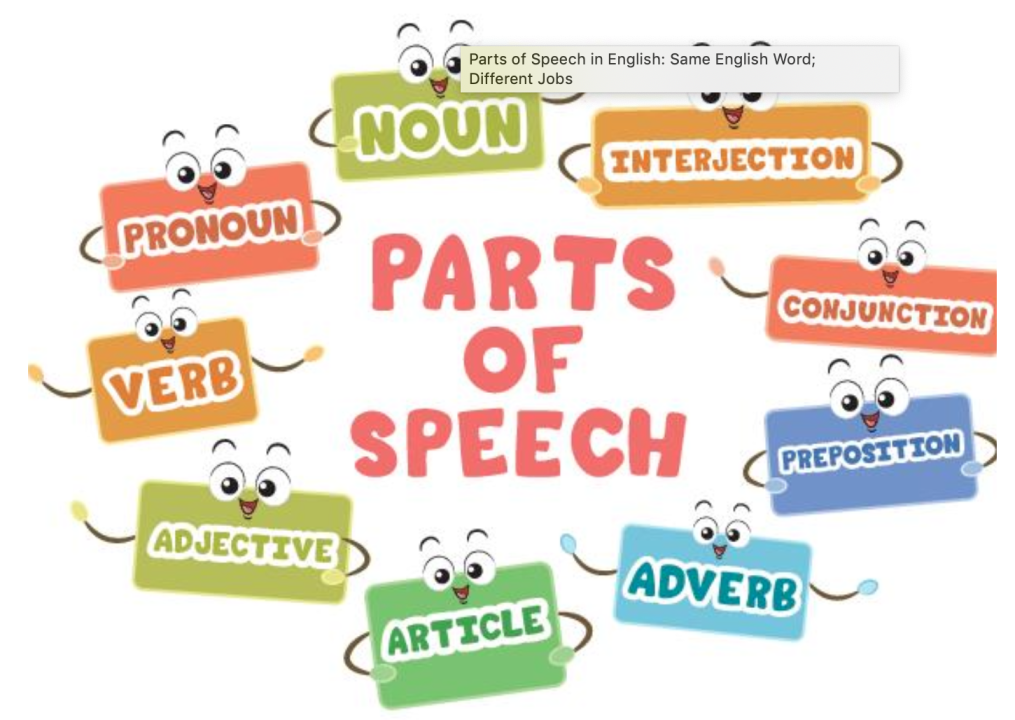

In [9]:
! pip install transformers datasets

In [10]:
pip install transformers datasets seqeval pyconll scikit-learn


In [11]:
pip install huggingface_hub[hf_xet]


In [12]:
pip install huggingface_hub[hf_xet]

In [13]:
pip install transformers datasets pyconll seqeval

In [14]:
pip install evaluate

In [ ]:
!pip install transformers

# Libraries

In [43]:
import pyconll
from transformers import AutoTokenizer
from datasets import Dataset

from collections import Counter
import plotly.graph_objects as go
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoModelForTokenClassification, Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
import evaluate

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from tabulate import tabulate


# Load Arabic_POS.conllu dataset

In [16]:
data = pyconll.load_from_file('/content/Arabic_POS.conllu')

# Data prepration

## a.Extract sentences and their corresponding UPOS tags.


In [17]:
# lists to store sentences and tags
sentences, tags = [], []

# Iterate over each sentence
for sent in data:
    words, pos = [], []
    # Iterate over each token
    for token in sent:
        # Ensure that the UPOS tag is valid and not None.
        if token.upos != 'None' and token.upos is not None:
            words.append(token.form)
            pos.append(token.upos)
    sentences.append(words)
    tags.append(pos)

print(sentences[0])
print(tags[0])


['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']


### Simple EDA

In [18]:
for i in range(2):
    print(f"Sentence {i+1}: {sentences[i]}")
    print(f"Tags: {tags[i]}")
    print("-" * 50)


Sentence 1: ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
Tags: ['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']
--------------------------------------------------
Sentence 2: ['برلين', '15', '-', '7', '(', 'اف', 'ب', ')', '-', 'افادت', 'صحيفة', 'الاحد', 'الالمانية', '"', 'ويلت', 'ام', 'سونتاغ', '"', 'في', 'عدد', 'ها', 'الصادر', 'غدا', '،', 'ان', 'المستشار', 'غيرهارد', 'شرودر', 'يرفض', 'حصول', 'المجموعة', 'الاميركية', '"', 'جنرال', 'ديناميكس', '"', 'على', 'رخصة', 'ل', 'تصنيع', 'الدبابة', 'الالمانية', '"', 'ليوبارد', '2', '"', 'عبر', 'شراء', 'المجموعة', 'الحكومية', 'الاسبانية', 'ل', 'الأسلحة', '"', 'سانتا', 'بربارة', '"', '.']
Tags: ['X', 'NUM', 'PUNCT', 'NUM', 'PUNCT', 'X', 'X', 'PUNCT', 'PUNCT', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'PUNCT', 'X', 'X', 'X', 'PUNCT', 'ADP', 'NOUN', 'PRON', 'ADJ', 'NOUN', 'PUNCT', 'SCONJ', 'NOUN', 'X', 'X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'PUNCT', '

In [19]:
print(f"Number of sentences: {len(sentences)}")

Number of sentences: 6075


In [20]:
tag_counts = Counter([tag for sublist in tags for tag in sublist])

print("UPOS tag counts:")
for tag, count in tag_counts.most_common():
    print(f"{tag}: {count}")


UPOS tag counts:
NOUN: 74546
ADP: 33617
ADJ: 23498
PUNCT: 17511
VERB: 16789
CCONJ: 15803
X: 13747
PRON: 8533
NUM: 6010
DET: 4648
SCONJ: 4368
PART: 1709
AUX: 1699
ADV: 880
SYM: 329
PROPN: 187
INTJ: 7


In [21]:
sentence_lengths = [len(sentence) for sentence in sentences]
print(f"Average sentence length: {np.mean(sentence_lengths)}")
print(f"Max sentence length: {np.max(sentence_lengths)}")
print(f"Min sentence length: {np.min(sentence_lengths)}")


Average sentence length: 36.85283950617284
Max sentence length: 398
Min sentence length: 1


In [22]:
for i in range(10):
    print(f"Word: {sentences[i][0]}, UPOS Tag: {tags[i][0]}")

Word: برلين, UPOS Tag: X
Word: برلين, UPOS Tag: X
Word: و, UPOS Tag: CCONJ
Word: و, UPOS Tag: CCONJ
Word: و, UPOS Tag: CCONJ
Word: و, UPOS Tag: CCONJ
Word: و, UPOS Tag: CCONJ
Word: مقتل, UPOS Tag: NOUN
Word: لاغوس, UPOS Tag: X
Word: و, UPOS Tag: CCONJ


In [23]:
tag_list = [tag for sublist in tags for tag in sublist]
tag_counts = Counter(tag_list)

fig = go.Figure(data=[go.Bar(
    x=list(tag_counts.keys()),
    y=list(tag_counts.values())
)])
fig.update_layout(
    title="Distribution of UPOS Tags",
    xaxis_title="UPOS Tags",
    yaxis_title="Frequency",
    xaxis_tickangle=45,
    xaxis={'tickmode': 'array', 'tickvals': list(tag_counts.keys())},
    template="plotly_dark",
    autosize=True,
    margin=dict(l=50, r=50, t=50, b=150)
)
fig.show()


## b.Tokenize and align tokens with POS labels to fit the Hugging Face token classification format.


In [24]:
# mapping UPOS tags to integers
unique_upos_tags = set()
for sentence_tags in tags:
    unique_upos_tags.update(sentence_tags)
unique_upos_tags = sorted(list(unique_upos_tags))
label2id = {label: i for i, label in enumerate(unique_upos_tags)}
id2label = {i: label for label, i in label2id.items()}
print("Unique UPOS tags:", unique_upos_tags)

Unique UPOS tags: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


In [25]:
tokenizer = AutoTokenizer.from_pretrained('asafaya/bert-base-arabic')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [26]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(label2id[example["ner_tags"][word_idx]])
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [27]:
# Prepare the data
tokenized_data = []
for sentence, upos_tags in zip(sentences, tags):
    tokenized_data.append({
        'tokens': sentence,
        'ner_tags': upos_tags
    })

In [28]:
# Create a Hugging Face dataset
dataset = Dataset.from_list(tokenized_data)

# Apply tokenization and alignment
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=False)

tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
print(tokenized_datasets[0])

Map:   0%|          | 0/6075 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([    2, 15978, 15248,  6329,  2265, 20618,  1747, 11777, 11298,  7855,
         2149,     6, 16054,  1892,  1045,     6,  6586,     3]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'labels': tensor([-100,   16,   15,    7,    7,    0,    1,    7,    7,    7, -100,   12,
          16, -100, -100,   12,    0, -100])}


## Data Spliting

#### split the dataset into training, validation, and test set :

70% for training

15% for validation

15% for testing

In [29]:
train_val, test = tokenized_datasets.train_test_split(test_size=0.15, seed=42).values()
train, val = train_val.train_test_split(test_size=0.1765, seed=42).values()

print(f"Train dataset size: {len(train)}")
print(f"Validation dataset size: {len(val)}")
print(f"Test dataset size: {len(test)}")

Train dataset size: 4251
Validation dataset size: 912
Test dataset size: 912


In [30]:
train_data=Dataset.from_list(train)
val_data=Dataset.from_list(val)
test_data=Dataset.from_list(test)

------------------------------------------------------
# Model Building

### **bert-base-multilingual-cased**

In [31]:
model =AutoModelForTokenClassification.from_pretrained('asafaya/bert-base-arabic',num_labels=len(label2id),id2label=id2label,label2id=label2id)


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at asafaya/bert-base-arabic and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
data_collator = DataCollatorForTokenClassification(tokenizer)

### Evaluate

In [33]:
seqeval = evaluate.load("seqeval")

In [34]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_preds = []
    true_labels = []

    for pred, label in zip(predictions, labels):
        pred_labels = []
        true_labels_seq = []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                pred_labels.append(id2label[p_i])
                true_labels_seq.append(id2label[l_i])
        true_preds.append(pred_labels)
        true_labels.append(true_labels_seq)

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


### Train

In [35]:
training_args = TrainingArguments(
    output_dir="results_dir",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=500,
    save_steps=1000,
    do_eval=True,
    do_train=True,
    do_predict=True
)


In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



<ipython-input-36-f726c8dd7a30>:1: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [37]:
from accelerate import Accelerator

accelerator = Accelerator()


In [38]:
import wandb
wandb.init(project="pos_tags", name="Nagwa")


trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nagwammatia919 (nagwammatia919-iti) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
500,0.284100
1000,0.097600
1500,0.073900


TrainOutput(global_step=1596, training_loss=0.14675355674628926, metrics={'train_runtime': 271.1414, 'train_samples_per_second': 47.034, 'train_steps_per_second': 5.886, 'total_flos': 588078588471642.0, 'train_loss': 0.14675355674628926, 'epoch': 3.0})

In [39]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

CCONJ seems not to be NE tag.

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

ADP seems not to be NE tag.

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

NOUN seems not to be NE tag.

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

ADJ seems not to be NE tag.

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

PUNCT seems not to be NE tag.

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

VERB seems not to be NE tag.

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

PRON seems not to be NE tag.

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:

X seems not to be NE t

{'eval_loss': 0.09882738441228867,
 'eval_precision': 0.9631442948456412,
 'eval_recall': 0.9619995245695656,
 'eval_f1': 0.9625715693436857,
 'eval_accuracy': 0.9728716236011016,
 'eval_runtime': 6.1878,
 'eval_samples_per_second': 147.387,
 'eval_steps_per_second': 18.423,
 'epoch': 3.0}

----------------------------------
# Test

In [40]:
predictions, label_ids, _ = trainer.predict(test_data)

In [41]:
predictions_output = trainer.predict(test_data)
logits = predictions_output.predictions
labels = predictions_output.label_ids
input_ids = test_data["input_ids"]
preds = np.argmax(logits, axis=2)
probs = np.max(np.exp(logits) / np.sum(np.exp(logits), axis=2, keepdims=True), axis=2)
import pandas as pd

rows = []

for sent_idx in range(len(input_ids)):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[sent_idx])
    pred_ids = preds[sent_idx]
    label_ids = labels[sent_idx]
    prob_scores = probs[sent_idx]

    for tok, pred_id, label_id, score in zip(tokens, pred_ids, label_ids, prob_scores):
        if label_id == -100:
            continue
        rows.append({
            "Token": tok,
            "Prediction": id2label[pred_id],
            "True Label": id2label[label_id],
            "Confidence Score": round(float(score), 4)
        })

df = pd.DataFrame(rows)
from IPython.display import display
display(df.head(50))


,Token,Prediction,True Label,Confidence Score
0,و,CCONJ,CCONJ,0.9998
1,هدد,VERB,VERB,0.9998
2,نواب,NOUN,NOUN,0.9988
3,موثر,ADJ,X,0.9909
4,من,ADP,ADP,0.9998
5,حركة,NOUN,NOUN,0.9992
6,فتح,X,X,0.6922
7,ب,ADP,ADP,0.9999
8,حجب,NOUN,NOUN,0.9994
9,الثقة,NOUN,NOUN,0.9992


# Let`s tray our model

In [45]:
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer)
text = "أحمد بن فهد يعمل في شركة أكسنتشر في دبي"

entities = nlp_ner(text)
df = pd.DataFrame(entities)

print(df[['word', 'entity', 'score']])

Device set to use cuda:0


    word entity     score
0   احمد      X  0.914691
1     بن  PROPN  0.986668
2    فهد      X  0.947396
3   يعمل   VERB  0.991479
4     في    ADP  0.999682
5   شركة   NOUN  0.998386
6    اكس      X  0.997006
7   ##نت      X  0.990624
8   ##شر      X  0.989105
9     في    ADP  0.999439
10   دبي      X  0.968035
